In [15]:
import numpy as np
import odl # the Operator Discretization Library

In [19]:

# Choice between Filtered Backprojection (FBP), Tikhonov, Total Variation(TV) and Entropy
regularization = "Tikhonov"
# The regularization parameter
a=1
# The reconstuction space
space = odl.uniform_discr(min_pt=[-20, -20], max_pt=[20, 20],
    shape=[512, 512])
# Number of projection angles and their distribution
angle_partition = odl.uniform_partition(0, np.pi, 180)
# Detector partition
detector_partition = odl.uniform_partition(-30, 30, 256)
# The detector geometry
geometry = odl.tomo.Parallel2dGeometry(angle_partition,
    detector_partition)
# The ray transform
ray_trafo = odl.tomo.RayTransform(space, geometry)
# The phantom
phantom = odl.phantom.shepp_logan(space, modified=True)
# Generate data
data = ray_trafo(phantom)
# Adding white Gaussian noise, approximately 5% signal-to-noise ratio
raw_noise = odl.phantom.white_noise(ray_trafo.range)
data += raw_noise/raw_noise.norm()*data.norm()*0.05


/Users/saityada/miniconda3/envs/illpropinverse/lib/python3.11/site-packages/odl/tomo/operators/ray_trafo.py:129: RuntimeWarning: The best available backend ('astra_cpu') may be too slow for volumes of this size. Consider using 'astra_cuda' if your machine has an Nvidia GPU. This warning can be disabled by explicitly setting `impl='astra_cpu'`.
  warnings.warn(


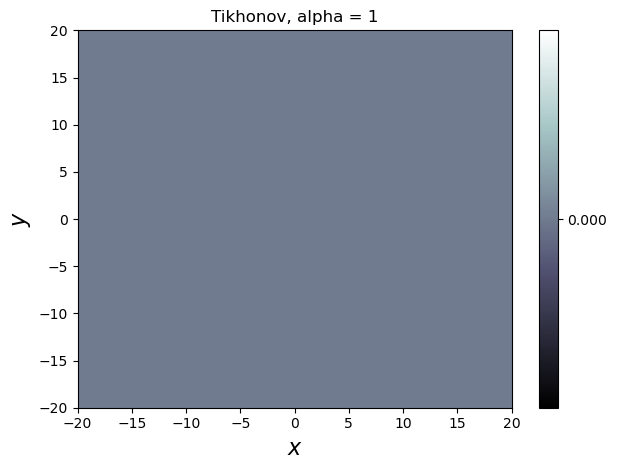

<Figure size 640x480 with 0 Axes>

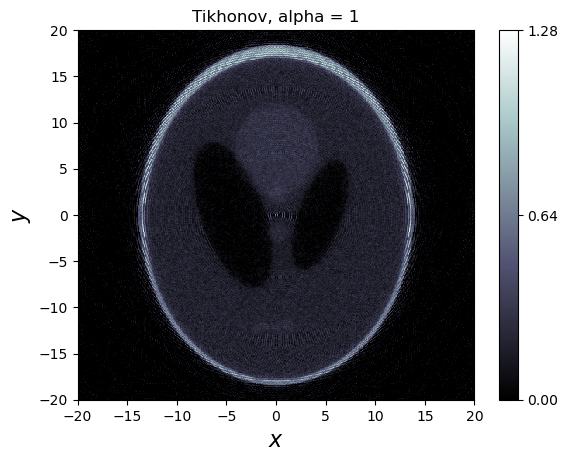

<Figure size 640x480 with 0 Axes>

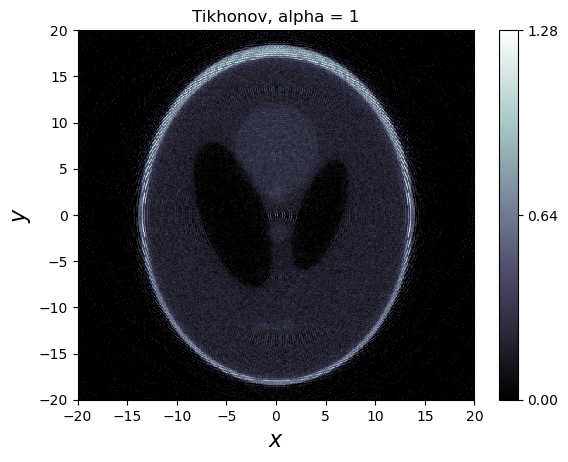

<Figure size 640x480 with 0 Axes>

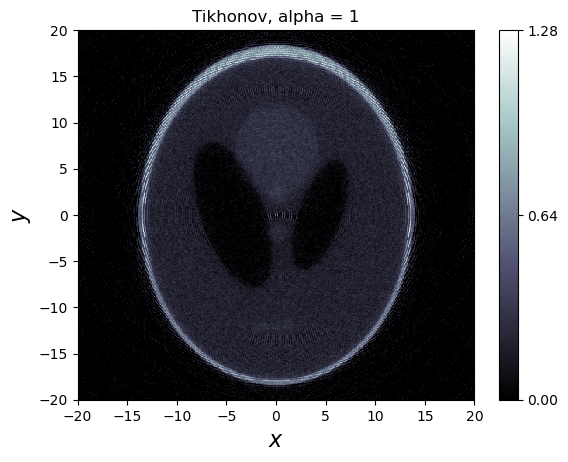

<Figure size 640x480 with 0 Axes>

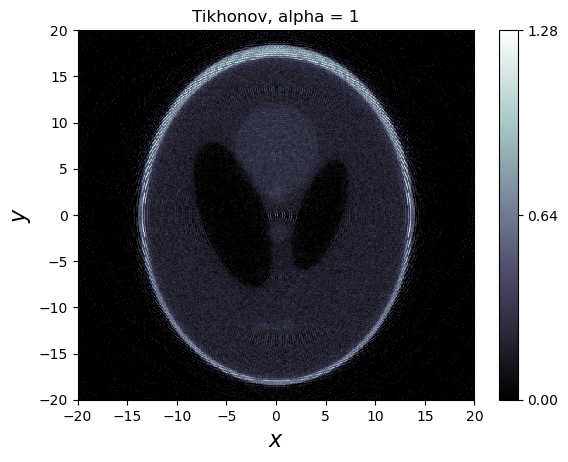

<Figure size 640x480 with 0 Axes>

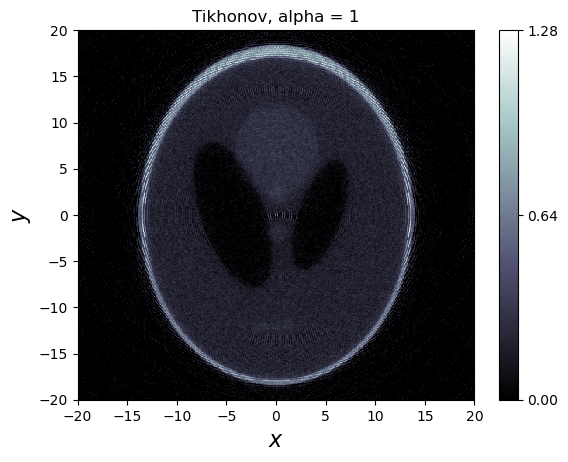

<Figure size 640x480 with 0 Axes>

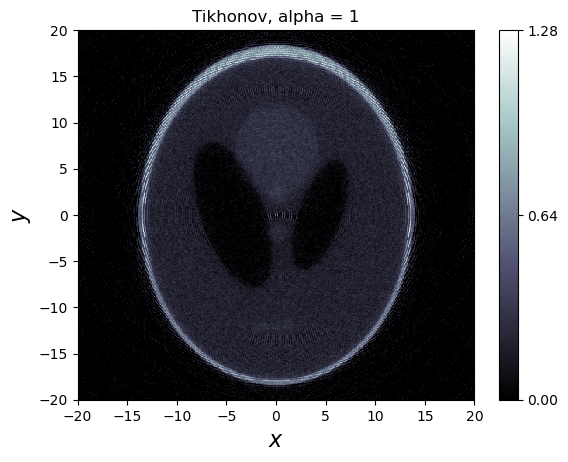

<Figure size 640x480 with 0 Axes>

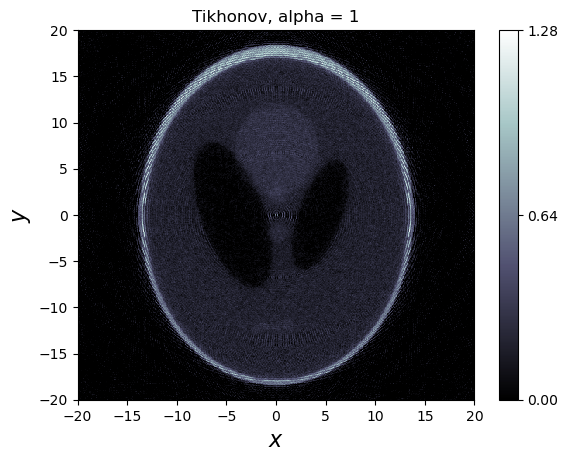

<Figure size 640x480 with 0 Axes>

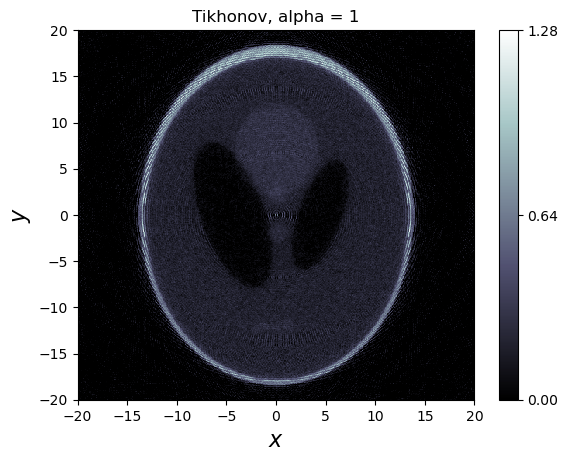

<Figure size 640x480 with 0 Axes>

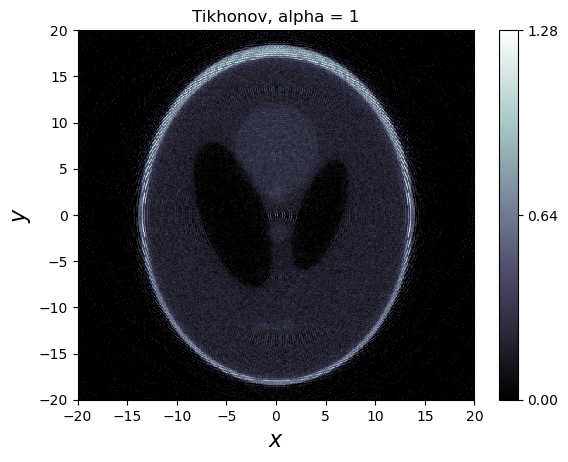

<Figure size 640x480 with 0 Axes>

In [31]:

if regularization == "FBP":
    # There are different filters in the fbp_op function, but we used 18 
    # the default one
    fbp_recon = odl.tomo.fbp_op(ray_trafo)(data)
    fbp_recon.show("FBP")
else:
    A = ray_trafo
    f = odl.solvers.IndicatorBox(space, 0)
    # the data-matching term
    g1 = odl.solvers.L2NormSquared(A.range).translated(data)
    
    if regularization == "Tikhonov":
        B = odl.IdentityOperator(space)
        # 2-norm squared of f
        g2 = a * odl.solvers.L2NormSquared(space)
        sigma = [0.2, 0.5]
        
    elif regularization == "TV":
        B = odl.Gradient(space)
        # 1-norm of the spatial gradient of f
        g2 = a * odl.solvers.L1Norm(B.range)
        sigma = [0.1, 0.02]
        
    elif regularization == "Entropy":
        B = odl.IdentityOperator(space)
        # the Kullback-Leibler functional
        g2 = a*odl.solvers.KullbackLeibler(space)
        sigma = [0.2, 0.5]
        
    else:
        raise RuntimeError("Unknown regularization")
    
    if not isinstance(A, odl.Operator):
        raise TypeError('`op` {!r} is not an `Operator` instance'
                        ''.format(A))
    if not isinstance(B, odl.Operator):
        raise TypeError('`op` {!r} is not an `Operator` instance'
                        ''.format(B))
    lin_ops = [A, B]
    # op = odl.BroadcastOperator(A,B)
    g_funcs = [g1, g2]
    x = A.domain.zero()
    call = (odl.solvers.CallbackShow(title=regularization + ", alpha = "
    +     str(a),step=100))
    odl.solvers.douglas_rachford_pd(x,f,g_funcs, lin_ops,
                            tau=0.1, sigma=sigma, niter=1000,
                                callback=call)